In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

E:\Anaconda3\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    x1 = np.random.uniform(-1, 1)
    x2 = np.random.uniform(0, 2)
    if x1 ** 2 + x2 ** 2 <= 1:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(0)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1)
print(data[0:10])

[[0.19550080626522343, 1.6544680526649849], [-0.05768155956963164, 1.2766525053035425], [0.9417298781181463, 0.9123103883478529], [0.18047544546240718, 1.8845607093227488], [1.1066445917812886, 1.577801302056867], [-1.0187501298455415, 1.3452039021990836], [-0.2439133133919853, 1.4030308114085568], [-0.809142477691444, 1.3822068711417825], [0.798717582266237, 1.1655609513845742], [0.5182914599273019, 0.24068892813698078]]


In [3]:
print(label[0:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


label shape: (150, 1)


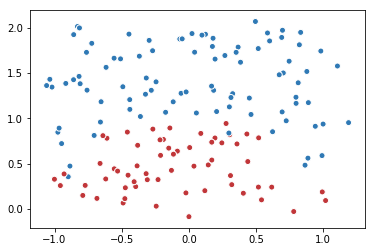

In [4]:
data = np.hstack(data).reshape(-1, 2)
label = np.hstack(label).reshape(-1, 1)
print('label shape:',label.shape)
plt.scatter(data[:, 0], data[:, 1], c=np.squeeze(label),
            cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()

In [5]:
# 获取一层神经网络边上的权重，并将这个权重的L2 正则化损失加入名称为'losses'的集合中
def get_weight(shape, lambda1):
    # 生成一个变量
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # add_to_collection 函数将这个新生成的变量的L2正则化损失项加入集合
    # 这个函数的第一个参数'losses' 是集合的名字，第二个参数是要加入集合的内容
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(var))
    return var

In [6]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
sample_size = len(data)
# 每层节点的个数
layer_dimension = [2, 10, 5, 3, 1]
# 神经网络的层数
n_layers = len(layer_dimension)
# 这个变量维护前向传播时最深沉的节点，开始的时候就是输入层
cur_layer = x
# 当前层节点的个数
in_dimension = layer_dimension[0]
# 循环生成网络结构
# 通过一个循环来生成5层全连接的神经网络
for i in range(1, n_layers):
    # layer_dimension[i] 为下一层节点的个数
    out_dimension = layer_dimension[i]
    # 生成当前权重的变量，并将这个变量的L2正则化损失加入计算图上的集合
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    # 使用ReLu激活函数
    # 书上为ReLU 源码为elu
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y = cur_layer

In [7]:
# 损失函数的定义。
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / sample_size
tf.add_to_collection('losses', mse_loss)
loss = tf.add_n(tf.get_collection('losses'))

In [8]:
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

In [9]:
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, loss: %f" % (i, sess.run(loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x: grid})
    probs = probs.reshape(xx.shape)

After 0 steps, loss: 16.338846
After 2000 steps, loss: 0.181959
After 4000 steps, loss: 0.142888
After 6000 steps, loss: 0.108195
After 8000 steps, loss: 0.078114
After 10000 steps, loss: 0.064551
After 12000 steps, loss: 0.060306
After 14000 steps, loss: 0.058731
After 16000 steps, loss: 0.058596
After 18000 steps, loss: 0.058544
After 20000 steps, loss: 0.058500
After 22000 steps, loss: 0.058455
After 24000 steps, loss: 0.058408
After 26000 steps, loss: 0.058357
After 28000 steps, loss: 0.058314
After 30000 steps, loss: 0.058278
After 32000 steps, loss: 0.058248
After 34000 steps, loss: 0.058224
After 36000 steps, loss: 0.058204
After 38000 steps, loss: 0.058189


In [12]:
print(label[0:5])

[[1]
 [1]
 [1]
 [1]
 [1]]


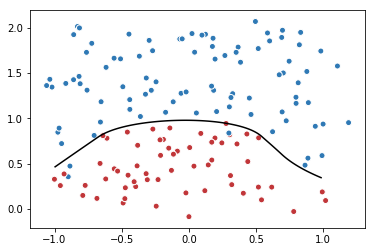

In [11]:
# squeeze 去掉一维
plt.scatter(data[:, 0], data[:, 1], c=np.squeeze(label),
            cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()